In [1]:
# Proof of concept implementation

In [2]:
import typing
import io
import os
import sys

from urllib.request import urlretrieve

from pytorch_pretrained_vit import ViT
import json
from PIL import Image
import torch
import torchvision
from torchvision import transforms
import cv2
import png
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from vit_models.modeling import VisionTransformer, CONFIGS

In [3]:
# Prepare labels and download ViT model
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [4]:
# Load data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


batch_size = 1
testset = torchvision.datasets.ImageFolder(root='./data/test/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
dataiter = iter(testloader)

In [5]:
# Helper functions for images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def tensor_to_image(img):
    img = img / 2 + 0.5 # unnormalize
    img = transforms.ToPILImage('RGB')(img.squeeze_(0))
    return img

#image, label = dataiter.next()
#image = tensor_to_image(image)

In [6]:
# Prepare Vision Transformer and helper functions
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

def plot_attention_map(logits, att_mat, image):

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(result)

    probs = torch.nn.Softmax(dim=-1)(logits)
    top5 = torch.argsort(probs, dim=-1, descending=True)
    print("Prediction Label and Attention Map!\n")
    for idx in top5[0, :5]:
        print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')


#im = Image.open("attention_data/img.jpg")
#x = transform(im)
#x.size()

def evaluate(image):
    
    # preprocessed_image = tfms(image).unsqueeze(0)
    x = transform(image)
    logits, att_mat = model(x.unsqueeze(0))
    
    plot_attention_map(logits, att_mat, image)
    

In [7]:
# Segmentation
# Code adapted from https://github.com/spmallick/learnopencv/blob/master/app-seperation-semseg/Background-Removal.py
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

# Apply the transformations needed
import torchvision.transforms as T

# Define the helper function
def decode_segmap(image, source, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])
  
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  
  rgb = np.stack([r, g, b], axis=2)

  # Load the foreground input image 
  foreground = source

  # Change the color of foreground image to RGB 
  # and resize image to match shape of R-band in RGB output map
  #foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(np.array(foreground),(r.shape[1],r.shape[0]))

  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)

  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)

  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)

  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255

  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)  
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)  

  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)

  # Return a normalized output image for display
  return outImage/255

def segment(net, image, show_orig=True, dev='cpu'):
    img = image
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(450), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  
    rgb = decode_segmap(om, img)
    #plt.axis('off'); 
    image = Image.fromarray((rgb * 255).astype(np.uint8))
    return image

---- Original ----
Prediction Label and Attention Map!

0.25279 : brambling, Fringilla_montifringilla
0.16003 : robin, American_robin, Turdus_migratorius
0.07625 : water_ouzel, dipper
0.03734 : junco, snowbird
0.03285 : house_finch, linnet, Carpodacus_mexicanus


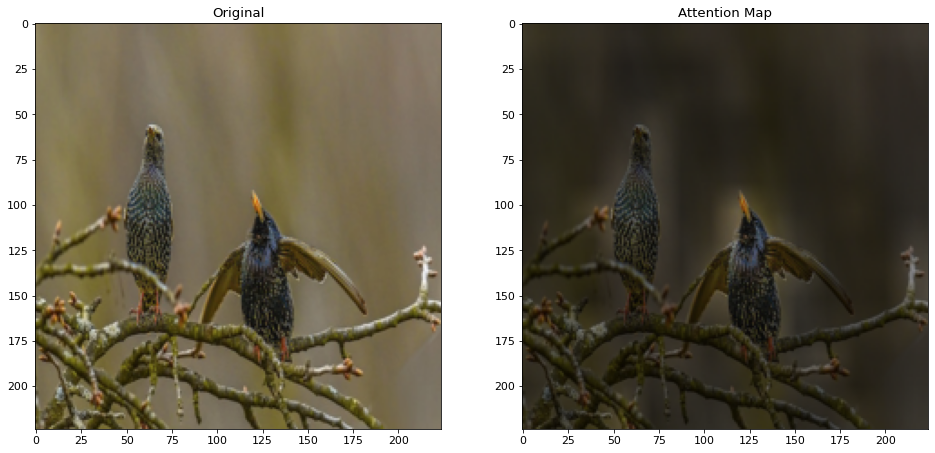

In [60]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

for x in range(1):
    image, label = dataiter.next()
    image = image / 2 + 0.5 # unnormalize
    image = transforms.ToPILImage('RGB')(image.squeeze_(0))
    print('---- Original ----')
    evaluate(image)

---- Segmentation ----
Prediction Label and Attention Map!

0.20812 : black_grouse
0.11110 : partridge
0.06539 : prairie_chicken, prairie_grouse, prairie_fowl
0.05728 : ruffed_grouse, partridge, Bonasa_umbellus
0.04185 : brambling, Fringilla_montifringilla


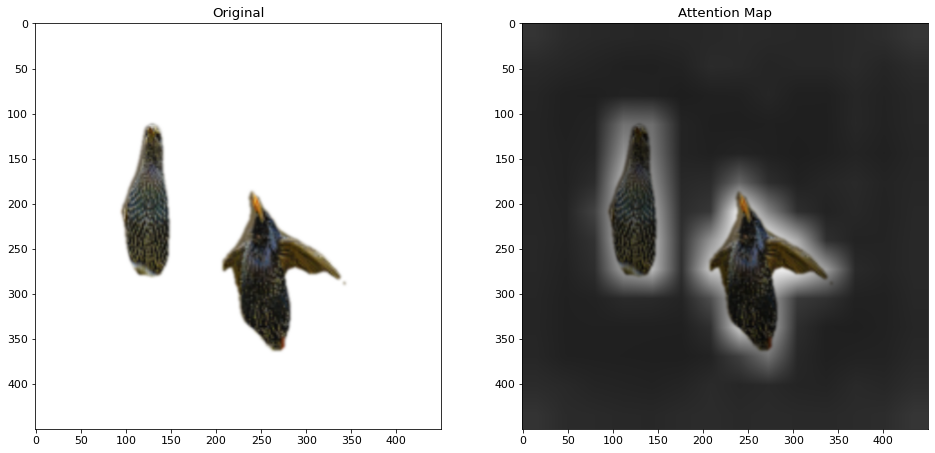

In [61]:
segmented_img = segment(dlab, image, show_orig=False)
print('---- Segmentation ----')
evaluate(segmented_img)

In [62]:
# Load pretrained YOLOv5 Object Detector
detector_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).autoshape()

Using cache found in /Users/lautenschlager/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-5-23 torch 1.8.1 CPU



AutoShape already enabled, skipping... 


In [63]:
results = detector_model(image, size=640)
results.print()
results.show()

image 1/1: 224x224 2 birds
Speed: 5.1ms pre-process, 264.9ms inference, 1.2ms NMS per image at shape (1, 3, 640, 640)


In [64]:
# Evaluate bounding boxes
results.pandas().xyxy
print(results.xyxy[0][0])

tensor([ 49.08541,  56.84821,  78.48044, 165.45825,   0.66913,  14.00000])


In [65]:
# Get bounding box coordinates from detection
#if results.pandas().xyxy.empty:
#    break
x1 = int(results.xyxy[0][0][0])
y1 = int(results.xyxy[0][0][1])
x2 = int(results.xyxy[0][0][2])
y2 = int(results.xyxy[0][0][3])
bbox_points=[x1, y1, x2, y2]
print('bounding box is:', x1, y1, x2, y2)

# Show cropped image (bounding box)
cropped_img = image.crop((x1, y1, x2, y2))
display(cropped_img)

bounding box is: 49 56 78 165


---- Cropped ----
Prediction Label and Attention Map!

0.56963 : brambling, Fringilla_montifringilla
0.10713 : partridge
0.10629 : black_grouse
0.03245 : prairie_chicken, prairie_grouse, prairie_fowl
0.02163 : water_ouzel, dipper


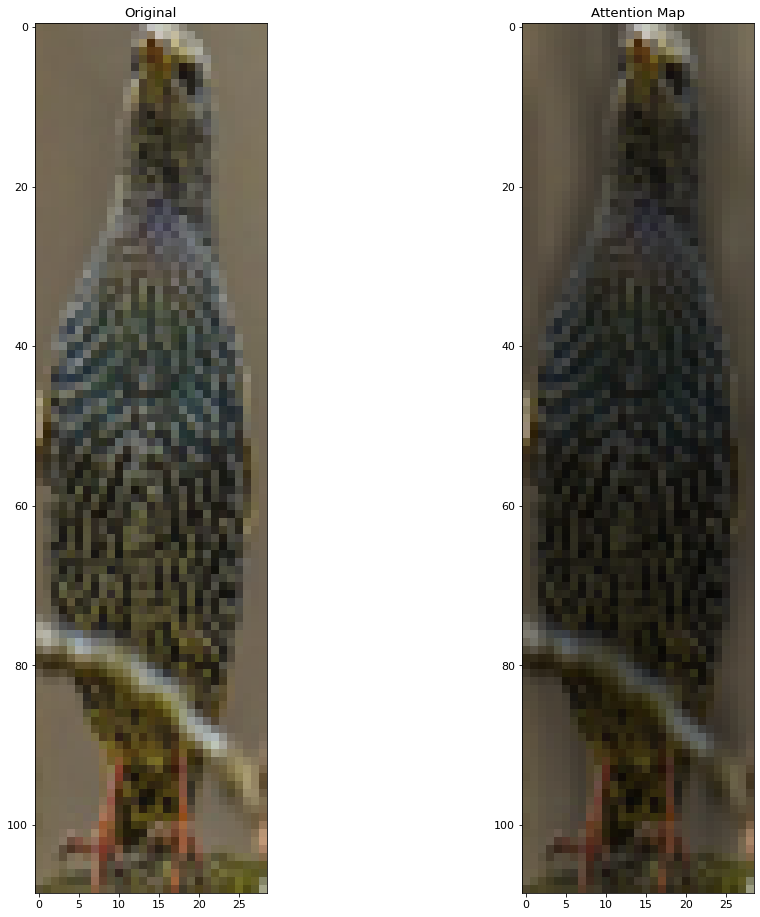

In [67]:
print('---- Cropped ----')
evaluate(cropped_img)

---- Cropped and segmented ----
Prediction Label and Attention Map!

0.57744 : partridge
0.17067 : black_grouse
0.08938 : ruffed_grouse, partridge, Bonasa_umbellus
0.04799 : prairie_chicken, prairie_grouse, prairie_fowl
0.03225 : ptarmigan


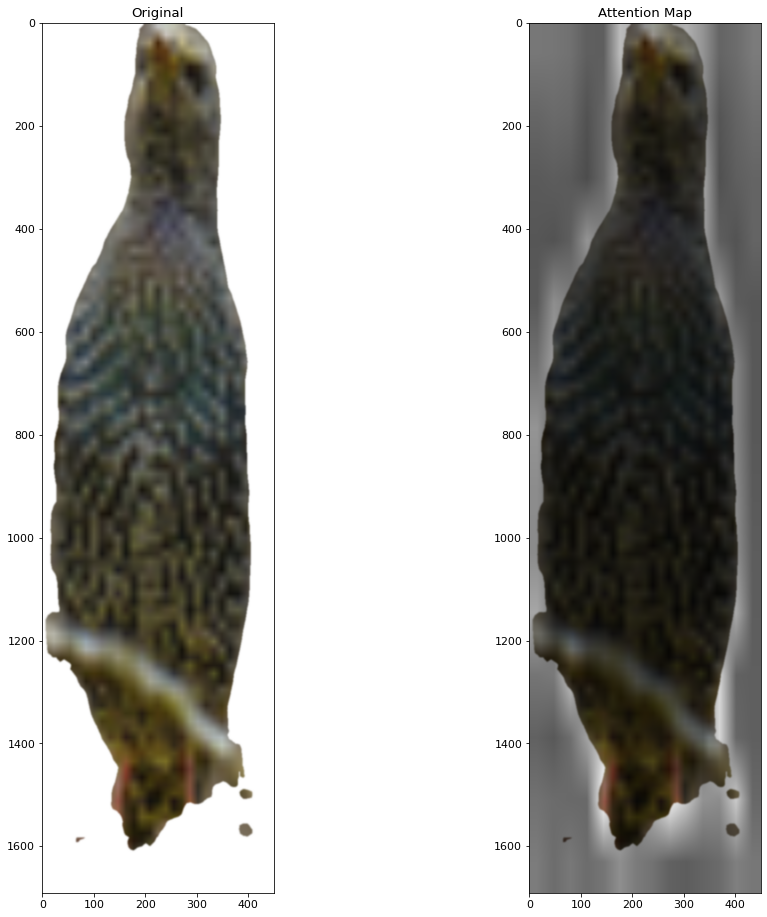

In [68]:
print('---- Cropped and segmented ----')
cropped_segmented_img = segment(dlab, cropped_img, show_orig=False)
evaluate(cropped_segmented_img)